In [86]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
#from PostStemmer import PostStemmer
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.pipeline import Pipeline
#from sklearn.base import TransformerMixin
#from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [88]:
# Turn JSON lines into JSON array
def json_line_to_array(filename):
    with open(filename) as f:
        lines = f.readlines()
        lines = map(lambda line: line.rstrip(), lines) #remove \n
        json_str = '[' + ','.join(lines) + ']'
        return json_str

In [89]:
# Read in downsampled balanced dataset
# Download data files from S3 to your local machine
# https://s3.amazonaws.com/boazreddit/data/balanced_multi.json
# https://s3.amazonaws.com/boazreddit/data/balanced_single.json
reddit_multi = pd.read_json(json_line_to_array('data/politicos/json/balanced_multi.json'))
reddit_single = pd.read_json(json_line_to_array('data/politicos/json/balanced_single.json'))

In [90]:
# Read in political sentiment (see 'Sentiment - Political Party.ipynb')
# Download data files from S3 to your local machine
# https://s3.amazonaws.com/boazreddit/data/balanced_multi_pol.json
# https://s3.amazonaws.com/boazreddit/data/balanced_single_pol.json
# multi_pol = pd.read_csv('data/politicos/json/balanced_multi_pol.csv', header=None, names=['pol_party'])
# reddit_multi['pol_party'] = multi_pol['pol_party']
# single_pol = pd.read_csv('data/politicos/json/balanced_single_pol.csv', header=None, names=['pol_party'])
# reddit_single['pol_party'] = single_pol['pol_party']

In [91]:
# Merge balanced dataset into a single dataframe
first_post = pd.concat([reddit_multi, reddit_single], axis=0)
del reddit_multi
del reddit_single

In [92]:
# Author- not needed in analysis, keep for now as index
first_post.set_index('author', inplace=True)
#first_post.drop('author', axis=1, inplace=True)

In [93]:
# Label / outcome variable
multi_post = first_post['total_posts']>1
first_post.drop(['total_posts', 'post_ids', 'post_datetimes', 'last_post_datetime'], axis=1, inplace=True)
multi_post.index.rename('multi_post', inplace=True)
multi_post.name = 'multi_post'

In [94]:
# Datetimes
pdt = pd.to_datetime(first_post['first_post_datetime'])
first_post.drop('first_post_datetime', axis=1, inplace=True)

# Date == days since Jan 1 2007
delta = pdt - pd.Timestamp('01-01-2007')
first_post['date'] = delta / np.timedelta64(1, 'D')

# Days of week (baseline Monday)
first_post['tues']    = pdt.apply(lambda ts: 1 if ts.dayofweek==1 else 0)
first_post['wed']     = pdt.apply(lambda ts: 1 if ts.dayofweek==2 else 0)
first_post['thurs']   = pdt.apply(lambda ts: 1 if ts.dayofweek==3 else 0)
first_post['fri']     = pdt.apply(lambda ts: 1 if ts.dayofweek==4 else 0)
first_post['sat']     = pdt.apply(lambda ts: 1 if ts.dayofweek==5 else 0)
first_post['sun']     = pdt.apply(lambda ts: 1 if ts.dayofweek==6 else 0)
#first_post['weekend'] = pdt.apply(lambda ts: 1 if ts.dayofweek==5 or ts.dayofweek==6 else 0)

# Daily and yearly cycles
first_post['time_of_day'] = pdt.apply(lambda ts: ts.minute + 60 * ts.hour)
first_post['day_of_year'] = pdt.apply(lambda ts: ts.dayofyear)

In [95]:
# Ups/downs
first_post.rename(columns={'first_post_ups':'ups',
                           'first_post_downs':'downs'}, inplace=True)
first_post['has_ups'] = first_post['ups'].apply(lambda ups: 1 if ups > 0 else 0)
#first_post['neg_ups'] = first_post['ups'].apply(lambda ups: 1 if ups < 0 else 0)
# bug: sample is missing downs

In [96]:
# Sentiment
#sentiment_clf = joblib.load('twitter_sentiment/classifier.pkl')

In [97]:
# Response sentiment

#response_sentiment = [] #proportion of responses that were positive
#sentiments = []
#pos_responses = []
#neg_responses = []

# for i,responses in enumerate(first_post['first_post_responses']):
#     if isinstance(responses, float): #NaNs due to no responses
#         #sentiments.append(None)
#         #pos_responses.append(0)
#         #neg_responses.append(0)
#         response_sentiment.append(0)
#     else: #utf8 encoding for classifier;
#         responses_utf8 = [response.encode('utf8') for response in responses]
#         responses_utf8_np = np.array(responses_utf8, ndmin=1)
#         responses_utf8_np.reshape(responses_utf8_np.shape[0],1) #explicit 1-dimension for classifier
#         responses_sentiments = sentiment_clf.predict(responses_utf8_np)
#         #sentiments.append(responses_sentiments)
#         #pos_responses.append(np.sum(responses_sentiments))
#         #neg_responses.append(responses_sentiments.shape[0] - np.sum(responses_sentiments))
#         response_sentiment.append( np.sum(responses_sentiments) / responses_sentiments.shape[0] )

# first_post['responses_sentiment'] = response_sentiment
#first_post['pos_responses'] = pos_responses
#first_post['neg_responses'] = neg_responses

In [98]:
# Body sentiment
# first_post_utf8 = first_post['first_post_body'].apply(lambda post: post.encode('utf8'))
# first_post['sentiment'] = sentiment_clf.predict(first_post_utf8).astype(int)

In [99]:
# Responses
first_post['responses_avg_word_ct'] = first_post['first_post_responses'].apply(lambda responses: 0 if isinstance(responses, float) else np.sum([len(response.split()) for response in responses]) * 1.0 / len(responses) )
first_post['has_short_response'] = first_post['first_post_responses'].apply(lambda responses: 0 if isinstance(responses, float) else (1 if np.max([len(response.split()) for response in responses])<=20 else 0))
first_post['has_long_response'] = first_post['first_post_responses'].apply(lambda responses: 0 if isinstance(responses, float) else (1 if np.max([len(response.split()) for response in responses])>20 else 0))
first_post.rename(columns={'first_post_avg_response_ups':'responses_ups_avg',
                           'first_post_avg_response_downs':'responses_downs_avg',
                           'first_post_total_responses':'responses_total'}, inplace=True)
first_post.drop(['first_post_responses','first_post_response_ups', 'first_post_response_downs'], axis=1, inplace=True) #not doing text analysis for now
first_post.fillna(0, inplace=True) #response stats are NaN if no responses
# responses_ups_avg is actually an interaction term multiplied by has_responses
#first_post['has_responses'] = (first_post['responses_total']>0).astype(int)

In [100]:
# Body
first_post['word_count'] = first_post['first_post_body'].apply(lambda post: len(post.split()))
first_post['long_post'] = first_post['word_count'].apply(lambda wc: 1 if wc > 20 else 0)
first_post.drop(['first_post_link_id', 'first_post_id', 'first_post_body'], axis=1, inplace=True)

In [101]:
# Parent type
first_post['is_response'] = first_post['parent_type']=='t1'
first_post['is_response'] = first_post['is_response'].astype(int)
first_post.drop('parent_type', axis=1, inplace=True)

In [102]:
# Downs and Response downs - drop bc no data in this sample
first_post.drop('responses_downs_avg', axis=1, inplace=True)
first_post.drop('downs', axis=1, inplace=True)

In [103]:
# Political party
# Removed bc doesn't have significant p-value, possibly due to poor accuracy in predicting political sentiment
# base case 0 is Conservative
# first_post['is_liberal'] = first_post['pol_party'].apply(lambda pol_party: 1 if pol_party=='Liberal' else 0)
# first_post['is_libertarian'] = first_post['pol_party'].apply(lambda pol_party: 1 if pol_party=='Libertarian' else 0)
# first_post['is_green'] = first_post['pol_party'].apply(lambda pol_party: 1 if pol_party=='Green' else 0)
# first_post.drop('pol_party', axis=1, inplace=True)

In [104]:
# Const
first_post = sm.add_constant(first_post)
#first_post['const'] = pd.Series(np.ones(first_post.shape[0]))

In [105]:
first_post.head()

,const,responses_ups_avg,responses_total,ups,date,tues,wed,thurs,fri,sat,sun,time_of_day,day_of_year,has_ups,responses_avg_word_ct,has_short_response,has_long_response,word_count,long_post,is_response
multi_post,,,,,,,,,,,,,,,,,,,,
EveryonesScreaming,1,-1.0000,1.0000,1,"3,051.5495",0,0,0,0,0,1,791,130,1,58.0000,0,1,256,1,1
timandrewsrg,1,0.0000,0.0000,1,"1,324.7015",1,0,0,0,0,0,1010,229,1,0.0000,0,0,22,1,0
karimowns,1,0.0000,0.0000,1,"3,043.8272",0,0,0,0,1,0,1191,122,1,0.0000,0,0,22,1,0
thatdevldog891,1,0.0000,0.0000,-2,"1,421.7341",0,0,0,0,0,0,1057,326,0,0.0000,0,0,7,0,0
benjy257,1,0.2500,4.0000,17,"1,126.1042",0,0,0,0,0,1,150,31,1,4.0000,1,0,19,0,1


In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

rfc = RandomForestClassifier(n_estimators=10, max_features=3, max_depth=5)

print 'accuracy', cross_val_score(rfc, first_post, multi_post, scoring='accuracy')
print 'precision', cross_val_score(rfc, first_post, multi_post, scoring='precision')
print 'recall', cross_val_score(rfc, first_post, multi_post, scoring='recall')

accuracy [ 0.63295704  0.62616126  0.63992003]
precision [ 0.63669176  0.63829787  0.63580782]
recall [ 0.9564604   0.93010132  0.92715147]


In [107]:
rfc.fit(first_post, multi_post)
feat_impt = zip(first_post.columns, rfc.feature_importances_)
sorted(feat_impt, key=lambda (colname, score): score, reverse=True)

[('date', 0.3998330364048),
 ('responses_avg_word_ct', 0.17622175487595601),
 ('responses_ups_avg', 0.13581892123860467),
 ('word_count', 0.054359464837544627),
 ('has_long_response', 0.052226915005203919),
 ('responses_total', 0.046029512521690505),
 ('long_post', 0.043341472840644248),
 ('ups', 0.032798022531402335),
 ('is_response', 0.031281078282093699),
 ('day_of_year', 0.0077903220524825042),
 ('has_short_response', 0.007646488668645657),
 ('time_of_day', 0.0075297296995066225),
 ('has_ups', 0.0017331241378215323),
 ('sat', 0.0007783331274437902),
 ('tues', 0.00073975206441365246),
 ('thurs', 0.00066646513559538386),
 ('wed', 0.00044847730670405432),
 ('fri', 0.00041919100044533389),
 ('sun', 0.00033793826900145585),
 ('const', 0.0)]

In [108]:
logit = sm.Logit(multi_post, first_post)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.637884
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             multi_post   No. Observations:                76534
Model:                          Logit   Df Residuals:                    76514
Method:                           MLE   Df Model:                           19
Date:                Tue, 01 Sep 2015   Pseudo R-squ.:                 0.04534
Time:                        12:35:52   Log-Likelihood:                -48820.
converged:                       True   LL-Null:                       -51138.
                                        LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     1.2897      0.044     29.520      0.000         1.204     1.375
responses_ups_avg        -0.0026      0.002     -1.334      0.182        -0.006     0.001
responses_total          -0.0008      0.002     -0.464      0.643        -0.004     0.003
ups                       0.0003      0.000      1.138      0.255        -0.000     0.001
date                     -0.0007   1.41e-05    -46.525      0.000        -0.001    -0.001
tues                     -0.0207      0.029     -0.723      0.470        -0.077     0.035
wed                      -0.0185      0.028     -0.651      0.515        -0.074     0.037
thurs                    -0.0536      0.028     -1.887      0.059        -0.109     0.002
fri                      -0.0279      0.029     -0.975      0.330        -0.084     0.028
sat                      -0.0286      0.030     -0.937      0.349        -0.088     0.031
sun                      -0.0211      0.030     -0.693      0.488        -0.081     0.039
time_of_day            5.832e-05   1.73e-05      3.365      0.001      2.44e-05  9.23e-05
day_of_year               0.0001   7.17e-05      1.939      0.053     -1.51e-06     0.000
has_ups                  -0.0736      0.020     -3.621      0.000        -0.114    -0.034
responses_avg_word_ct     0.0012      0.000      3.523      0.000         0.001     0.002
has_short_response        0.4105      0.023     18.183      0.000         0.366     0.455
has_long_response         0.6368      0.029     21.885      0.000         0.580     0.694
word_count                0.0002      0.000      1.187      0.235        -0.000     0.000
long_post                 0.2206      0.018     12.379      0.000         0.186     0.256
is_response               0.2980      0.016     18.884      0.000         0.267     0.329
=========================================================================================
"""

In [109]:
np.exp(result.params)

const                   3.6317
responses_ups_avg       0.9974
responses_total         0.9992
ups                     1.0003
date                    0.9993
tues                    0.9795
wed                     0.9817
thurs                   0.9478
fri                     0.9725
sat                     0.9718
sun                     0.9791
time_of_day             1.0001
day_of_year             1.0001
has_ups                 0.9290
responses_avg_word_ct   1.0013
has_short_response      1.5076
has_long_response       1.8905
word_count              1.0002
long_post               1.2468
is_response             1.3472
dtype: float64

In [110]:
result.aic

97679.643959987399

In [111]:
logit2 = sm.Logit(multi_post, first_post[[  'const',
                                            'date',
                                            'long_post',
                                            #'has_ups', 
                                            'has_short_response', 
                                            'has_long_response',
                                            'is_response'
                                         ]])
result2 = logit2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.638212
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             multi_post   No. Observations:                76534
Model:                          Logit   Df Residuals:                    76528
Method:                           MLE   Df Model:                            5
Date:                Tue, 01 Sep 2015   Pseudo R-squ.:                 0.04485
Time:                        12:35:53   Log-Likelihood:                -48845.
converged:                       True   LL-Null:                       -51138.
                                        LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                  1.2742      0.030     43.165      0.000         1.216     1.332
date                  -0.0007   1.41e-05    -46.682      0.000        -0.001    -0.001
long_post              0.2356      0.016     15.014      0.000         0.205     0.266
has_short_response     0.4183      0.022     19.297      0.000         0.376     0.461
has_long_response      0.7057      0.021     33.755      0.000         0.665     0.747
is_response            0.2950      0.016     18.801      0.000         0.264     0.326
======================================================================================
"""

In [112]:
result2.aic

97701.815541465839

In [113]:
# Convert word counts to 10-word counts 
result2_params = result2.params.copy()
# result2_params['responses_avg_word_ct'] = result2_params['responses_avg_word_ct'] *10
# result2_params['word_count'] = result2_params['word_count'] *10

In [114]:
odds_pvals = pd.concat([np.exp(result2_params), result2.pvalues], axis=1)
odds_pvals.columns = ['Odds Ratio', 'P-val']
odds_pvals.sort('Odds Ratio', ascending=False, inplace=True)
pd.options.display.float_format = '{:,.4f}'.format
odds_pvals
# note these are odds ratios for 10-word counts

,Odds Ratio,P-val
const,3.5758,0.0000
has_long_response,2.0253,0.0000
has_short_response,1.5194,0.0000
is_response,1.3431,0.0000
long_post,1.2657,0.0000
date,0.9993,0.0000


In [115]:
#print np.exp(result2.params['has_responses'])
print np.exp( (result2.params['has_short_response'] + result2.params['has_long_response']) / 2.0 )

1.75418609251


In [116]:
logit3 = sm.Logit(multi_post, first_post[[  'const',
                                            'date',
                                            'long_post',
                                            #'has_ups', 
                                            'has_short_response', 
                                            'has_long_response',
                                            'is_response' ]])
result3 = logit3.fit()
#result3.summary()

odds_pvals = pd.concat([np.exp(result3.params), result3.pvalues], axis=1)
odds_pvals.columns = ['Odds Ratio', 'P-val']
odds_pvals.sort('Odds Ratio', ascending=False, inplace=True)
pd.options.display.float_format = '{:,.4f}'.format
odds_pvals

Optimization terminated successfully.
         Current function value: 0.638212
         Iterations 5


,Odds Ratio,P-val
const,3.5758,0.0000
has_long_response,2.0253,0.0000
has_short_response,1.5194,0.0000
is_response,1.3431,0.0000
long_post,1.2657,0.0000
date,0.9993,0.0000


In [117]:
result3.aic

97701.815541465839

In [118]:
# Pct with responses
print 'Any response', (np.sum(first_post['has_short_response'])+np.sum(first_post['has_short_response'])) * 1.0 / first_post.shape[0]
print 'Short response', np.sum(first_post['has_short_response']) * 1.0 / first_post.shape[0]
print 'Long response', np.sum(first_post['has_long_response']) * 1.0 / first_post.shape[0]

Any response 0.324065121384
Short response 0.162032560692
Long response 0.213852666789


In [119]:
response = first_post.apply(lambda user: 'none' if user['responses_total']==0 else 'short' if user['has_short_response']==1 else 'long', axis=1)
pd.crosstab(response, multi_post)

multi_post,False,True
row_0,,
long,4385,11982
none,21206,26560
short,4160,8241


In [120]:
pd.crosstab(response, multi_post).apply(lambda row: row / row.sum(), axis=1)

multi_post,False,True
row_0,,
long,0.2679,0.7321
none,0.4440,0.5560
short,0.3355,0.6645


In [121]:
#np.mean(np.logical_and(first_post['has_ups'], np.logical_not(first_post['has_responses'])))

Getting feedback on first posts is associated with posting again in Reddit Politics.
- Receiving at least one response to first comment associated with 71% better odds of posting again (p &lt; 0.001)
- Receiving at least one upvote to first comment associated with 41% better odds of posting again (p &lt; 0.001)
    
Participating in dialog was also associated with posting again. Users whose first comment was in response to another comment had 47% better odds of posting again (p &lt; 0.001). (This was after controlling for similar number of responses and upvotes, so it's not because responding to others makes them more likely to get responses in return.)

Length of first comments and responses to first comments were somewhat positively associated with higher probability of posting again, although the effect size was smaller and statistical significance was weaker. For each additional 10 words in their first comment, users had 2.1% higher odds of commenting again (p=0.005). For each additional 10 words on average in the responses to their first comment, users had 2.7% higher odds of commenting again, although the result was not statistically significant (p=0.113).

All results were controlled for yearly seasonality, and absolute date across site history.

In [122]:
odds_ratios = np.exp(result2.params).sort(ascending=False, inplace=False)
print odds_ratios

const                3.5758
has_long_response    2.0253
has_short_response   1.5194
is_response          1.3431
long_post            1.2657
date                 0.9993
dtype: float64


In [123]:
features = first_post[[ 'const',
                        'date',
                        'has_ups', 
                        'has_short_response', 
                        'has_long_response',
                        'long_post',
                        'is_response', ]]
sk_logit = LogisticRegression(fit_intercept=False)
accuracy_cv = cross_val_score(sk_logit, X=features, y=multi_post, scoring='accuracy', cv=5)
print 'model accuracy', np.mean(accuracy_cv)
recall_cv = cross_val_score(sk_logit, X=features, y=multi_post, scoring='recall', cv=5)
print 'model recall', np.mean(recall_cv)
auc_cv = cross_val_score(sk_logit, X=features, y=multi_post, scoring='roc_auc', cv=5)
print 'model auc', np.mean(auc_cv)

model accuracy 0.635521738163
model recall 0.863327080941
model auc 0.64122429819


Removing 'has_ups' slightly improves model predictive accuracy.

It makes AIC slightly worse. But I'm suspicious about accuracy of data and model interaction effects with has_ups, because its coefficient is counterintuitive, and Reddit says it fuzzes the ups data. Also, there was a bug in the code that prevented downs from propagating through the analysis, so that makes it harder to debug the problem.

With `has_ups`
```
model accuracy 0.634972933772
model recall 0.868906118759
model auc 0.641487062727
```

Without `has_ups`
```
model accuracy 0.635286522623
model recall 0.864417292717
model auc 0.640855335393
```

Yahoo Answers study, which included first-week engagement:
```
model accuracy: 0.691
model auc: 0.758
```

In [124]:
sk_dummy = DummyClassifier()
accuracy_cv = cross_val_score(sk_dummy, X=features, y=multi_post, scoring='accuracy', cv=5)
print 'model accuracy', np.mean(accuracy_cv)
auc_cv = cross_val_score(sk_dummy, X=features, y=multi_post, scoring='roc_auc', cv=5)
print 'model auc', np.mean(auc_cv)

model accuracy 0.524433497219
model auc 0.500135562474


Logistic regression model predicts ~20% more accurately than random guess.

In [125]:
# response_crosstab_scaled = response_crosstab / response_crosstab.sum(axis=0)
# response_crosstab_scaled`

In [126]:
# response_crosstab_scaled.T.plot(kind="bar", stacked=True)
# plt.title('Proportion who commented again,\n depending on whether or not they \nreceived a response to their first comment')

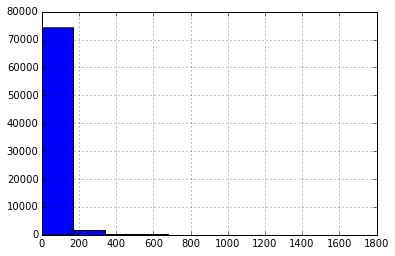

In [127]:
first_post.word_count.hist()

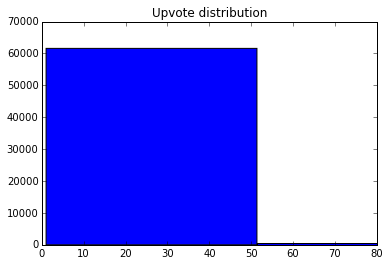

In [128]:
plt.figure()
plt.hist(first_post[first_post['ups']>0]['ups'], bins=75)
plt.xlim((0,80))
plt.title('Upvote distribution')

In [129]:
word_count_discrete = pd.cut(first_post.word_count, [0,50,100,150,200,800])

In [130]:
word_count_crosstab = pd.crosstab(multi_post, word_count_discrete)
word_count_crosstab

word_count,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 800]"
multi_post,,,,,
False,24453,3298,1005,427,553
True,35873,6744,2135,892,1108


In [131]:
word_count_crosstab_scaled = word_count_crosstab / word_count_crosstab.sum(axis=0)
word_count_crosstab_scaled

word_count,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 800]"
multi_post,,,,,
False,0.4053,0.3284,0.3201,0.3237,0.3329
True,0.5947,0.6716,0.6799,0.6763,0.6671


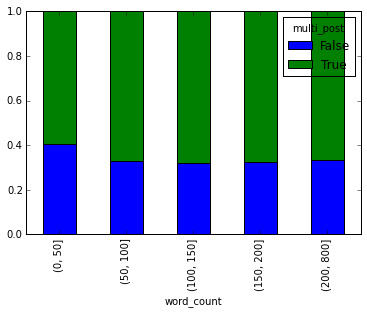

In [132]:
word_count_crosstab_scaled.T.plot(kind="bar", stacked=True)

More responses to mid-length comments -- consider feature for mid-length comments

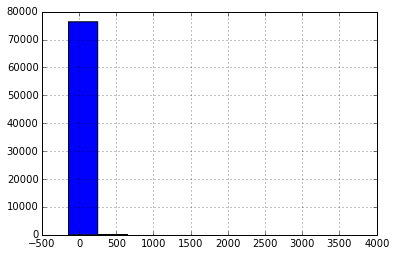

In [133]:
first_post.ups.hist()

In [134]:
ups_discrete = pd.cut(first_post.ups, [-100,-0.5,0.5,10,100,1000])

In [135]:
ups_crosstab = pd.crosstab(multi_post, ups_discrete)
ups_crosstab

ups,"(-100, -0.5]","(-0.5, 0.5]","(0.5, 10]","(10, 100]","(100, 1000]"
multi_post,,,,,
False,2480,2653,22615,1808,190
True,4594,3869,33918,3953,432


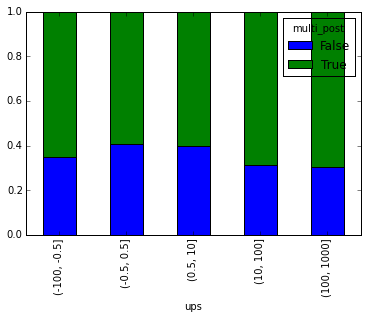

In [136]:
ups_crosstab_scaled = ups_crosstab / ups_crosstab.sum(axis=0)
ups_crosstab_scaled.T.plot(kind="bar", stacked=True)

Highly upvoted first_post more likely to repost

Are ups and has_responses collinear?

In [137]:
# ups_vs_has_responses = pd.crosstab(ups_discrete, first_post.has_responses)
# ups_vs_has_responses.T

In [138]:
# ups_vs_has_responses_scaled = ups_vs_has_responses.T / ups_vs_has_responses.sum(axis=1)
# ups_vs_has_responses_scaled

In [139]:
# ups_vs_has_responses_scaled.T.plot(kind="bar", stacked=True)

In [140]:
# first_post.apply(np.log).plot('ups','responses_total', kind="scatter")

More upvotes is correlated with having responses